In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm_notebook
from operator import itemgetter
import community


In [2]:
data1 = pd.read_csv("soc-redditHyperlinks-body.tsv", sep = '\t').drop(columns = ['PROPERTIES', 'POST_ID', 'TIMESTAMP'])
data2 = pd.read_csv("soc-redditHyperlinks-title.tsv", sep = '\t').drop(columns = ['PROPERTIES', 'POST_ID', 'TIMESTAMP'])

In [3]:
df = pd.DataFrame(columns=['source', 'target', 'weight'])
df['source'] = data1.SOURCE_SUBREDDIT
df['target'] = data1.TARGET_SUBREDDIT
df['weight'] = data1.LINK_SENTIMENT
df.head()
df.to_csv('copy.csv', index=False)
df = pd.concat([data1, data2])
# get unique subreddits
nodes = (set(df.SOURCE_SUBREDDIT.unique()) | set(df.TARGET_SUBREDDIT.unique()))
print("Number of subreddits :", len(nodes))
# get links 
edges = list(zip(df.SOURCE_SUBREDDIT, df.TARGET_SUBREDDIT, df.LINK_SENTIMENT))
print("Number of links :", len(edges))
G = nx.MultiDiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

Number of subreddits : 67180
Number of links : 858488


In [4]:
print("Strongly connected components : ",len(list(nx.strongly_connected_components(G))))
print("Weakly connected components : ",len(list(nx.weakly_connected_components(G))))

Strongly connected components :  45564
Weakly connected components :  712


In [191]:
[len(c) for c in sorted(nx.weakly_connected_components(G),
...                         key=len, reverse=True)][0:5]

[65648, 9, 8, 7, 7]

In [6]:
G1 = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])

In [14]:
print("Strongly connected components : ",len(list(nx.strongly_connected_components(G1))))
print("Weakly connected components : ",len(list(nx.weakly_connected_components(G1))))

Strongly connected components :  44064
Weakly connected components :  1


In [60]:
node_list = list(G1.nodes())


In [91]:
node_pos_max = {}
node_neg_max = {}

for node in node_list:
    nbr_pos_weight = {}
    nbr_neg_weight = {}
    for x in list(G.out_edges(node)):
        nbr_pos = 0
        nbr_neg = 0
        for edge in list((G.get_edge_data(x[0], x[1])).values()):
            if(edge['weight']>0):
                nbr_pos += edge['weight']
            if(edge['weight']<0):
                nbr_neg += edge['weight']
        nbr_pos_weight.update({x[1]: nbr_pos})
        nbr_neg_weight.update({x[1]: nbr_neg})
        
    if(len(nbr_pos_weight)==0):
        node_pos_max.update({node: None})
    else:
        n = max(nbr_pos_weight.items(), key=itemgetter(1))[0]
        node_pos_max.update({node: n})
    
    if(len(nbr_neg_weight)==0):
        node_neg_max.update({node: None})
    else:
        n = max(nbr_neg_weight.items(), key=itemgetter(1))[0]
        node_neg_max.update({node: n})


In [260]:
# output = dict.fromkeys(np.arange(1000, 1100, 100))
# for num_sims in tqdm_notebook(sorted(list(output.keys()))):
#     print(num_sims)
num_sims = 1000
score = dict.fromkeys(node_list)
time_for = dict.fromkeys(node_list)

for node in node_list:
    score[node] = 0
    time_for[node] = []
    askreddit = []
output = dict.fromkeys(range(10, 110, 10))
for tmax in tqdm_notebook(list(output.keys())):
    for sims in tqdm_notebook(range(num_sims)):
        start = np.random.choice(node_list)
        time = 0

        for iter in (range(tmax)):

            time = time + 1
            if(len(G1.out_edges(start))==0):
                start = np.random.choice(node_list)
                continue
            next_node = np.random.choice([x[1] for x in (G1.out_edges(start))])
            next_Edge = np.random.choice(list((G.get_edge_data(start, next_node)).values()))['weight']
            if(next_Edge < 0):
                score[next_node] -= 1
                time_for[next_node].append(time)
                break
            start = next_node 
        askreddit.append(score['askreddit'])

    #     print(min(score.items(), key=itemgetter(1)))
    output[tmax] = [(x[0], x[1], np.mean(time_for[x[0]])) for x in (sorted(score.items(), key = itemgetter(1)))]
    #     print(output[num_sims][0:5])
#     steps[sims] = time

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [261]:
print(output.keys())
for val in output:
    if(output[val] is None):
        print(val)
        continue
    print(val, len([x for x in output[val] if x[1]<0]))

dict_keys([80, 50, 20, 70, 40, 100, 10, 60, 90, 30])
80 494
50 767
20 920
70 1128
40 1279
100 1452
10 1513
60 1653
90 1783
30 1872


In [262]:
out = output[100]
counts=[]
times=[]
for t in range(int(tmax)):
    times.append(t)
    counts.append(len([x[1] for x in out if x[2]<t]))

In [268]:
for x in (out[0:10]):
    print(x[0], "&", x[1], "&", np.round(x[2]), "\\\\")
    print("\hline")

askreddit & -282 & 19.0 \\
\hline
pics & -129 & 18.0 \\
\hline
worldnews & -120 & 18.0 \\
\hline
funny & -117 & 17.0 \\
\hline
videos & -113 & 19.0 \\
\hline
todayilearned & -102 & 17.0 \\
\hline
adviceanimals & -84 & 19.0 \\
\hline
wtf & -82 & 18.0 \\
\hline
news & -72 & 22.0 \\
\hline
iama & -71 & 17.0 \\
\hline


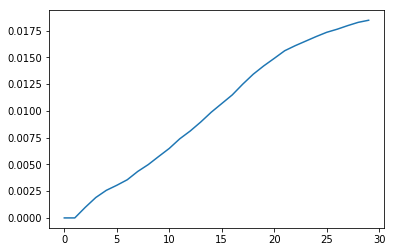

In [263]:
plt.plot(times, np.array(counts)/len(node_list))